# PrithviWxC Rollout Inference
If you haven't already, take a look at the exmaple for the PrithviWxC core
model, as we will pass over the points covered there.

Here we will introduce the PrithviWxC model that was trained furhter for
autoregressive rollout, a common strategy to increase accuracy and stability of
models when applied to forecasting-type tasks. 

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

# Set backend etc.
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

# Set seeds
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set variables
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

### Lead time
When performing auto-regressive rollout, the intermediate steps require the
static data at those times and---if using `residual=cliamte`---the intermediate
climatology. We provide a dataloader that extends the MERRA2 loader of the
core model, adding in these additional terms. Further, it return target data for
the intermediate steps if those are required for loss terms. 

The `lead_time` flag still lets the target time for the model, however now it
only a single value and must be a positive integer multiple of the `-input_time`. 

In [2]:
lead_time = 12  # This variable can be change to change the task
input_time = -6  # This variable can be change to change the task

We continue to setup the data paths and other variables as before.

In [3]:
time_range = ("2016-02-01T00:00:00", "2016-02-06T23:59:59")

surf_dir = Path("/some/path/to/merra_2/")
vert_dir = Path("/some/path/to/merra_2/")

surf_clim_dir = Path("/some/path/to/merra_2/climatology/")
vert_clim_dir = Path("some/path/to/merra_2/climatology/")

positional_encoding = "fourier"

### Dataloader init
We are now ready to instantiate the dataloader.

In [4]:
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset

dataset = Merra2RolloutDataset(
    time_range=time_range,
    lead_time=lead_time,
    input_time=input_time,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

## Model
### Scalers and other hyperparameters
Again, this setup is similar as before.

In [5]:
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)

surf_in_scal_path = Path("/path/to/musigma_surface.nc")
vert_in_scal_path = Path("/path/to/musigma_vertical.nc")
surf_out_scal_path = Path("/path/to/anomaly_variance_surface.nc")
vert_out_scal_path = Path("/path/to/anomaly_variance_vertical.nc")

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

residual = "climate"
masking_mode = "local"
decoder_shifting = True
masking_ratio = 0.99

### Model init
We can now build and load the pretrained weights, note that you should use the
rollout version of the weights.

In [6]:
from PrithviWxC.model import PrithviWxC

model = PrithviWxC(
    in_channels=160,
    input_size_time=2,
    in_channels_static=8,
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=0.0,
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=0.0,
    output_scalers=output_sig**0.5,
    n_lats_px=360,
    n_lons_px=576,
    patch_size_px=[2, 2],
    mask_unit_size_px=[30, 32],
    mask_ratio_inputs=masking_ratio,
    embed_dim=2560,
    n_blocks_encoder=12,
    n_blocks_decoder=2,
    mlp_multiplier=4,
    n_heads=16,
    dropout=0.0,
    drop_path=0.0,
    parameter_dropout=0.0,
    residual=residual,
    masking_mode=masking_mode,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)

weights_path = Path("/some/path/to/rollout_weights.pt")

state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Rollout
We are now ready to perform the rollout. Agin the data has to be run through a
preprocessor. However this time we use a preprocessor that can handle the
additional intermediate data. Also, rather than calling the model directly, we
have a conveient wrapper function that performs the interation. This also
simplifies the model loading when using a sharded cahckpoint. If you attempt to
perform training steps upton this function, we should use an aggressive number
of activation checkpoints as the memory consumption becomes quite high.

In [7]:
from PrithviWxC.dataloaders.merra2_rollout import preproc
from PrithviWxC.rollout import rollout_iter

data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = rollout_iter(dataset.nsteps, model, batch)

## Plotting

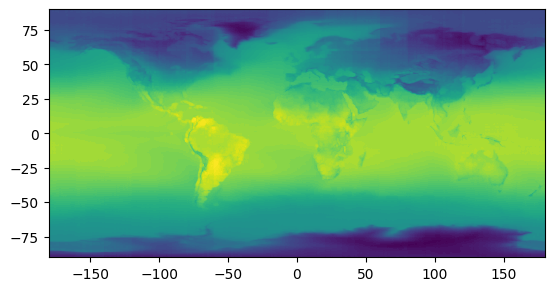

In [8]:
t2m = out[0, 12].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

plt.contourf(X, Y, t2m, 100)
plt.gca().set_aspect("equal")
plt.show()